In [135]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, learning_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, classification_report,ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# --------------------------------------------------------------------------------------------------
# Data loading
df_train = pd.read_csv('bank_train.csv')
df_test = pd.read_csv('bank_test.csv')

print('----loaded the datasets----')

----loaded the datasets----


## PREPROCESSING

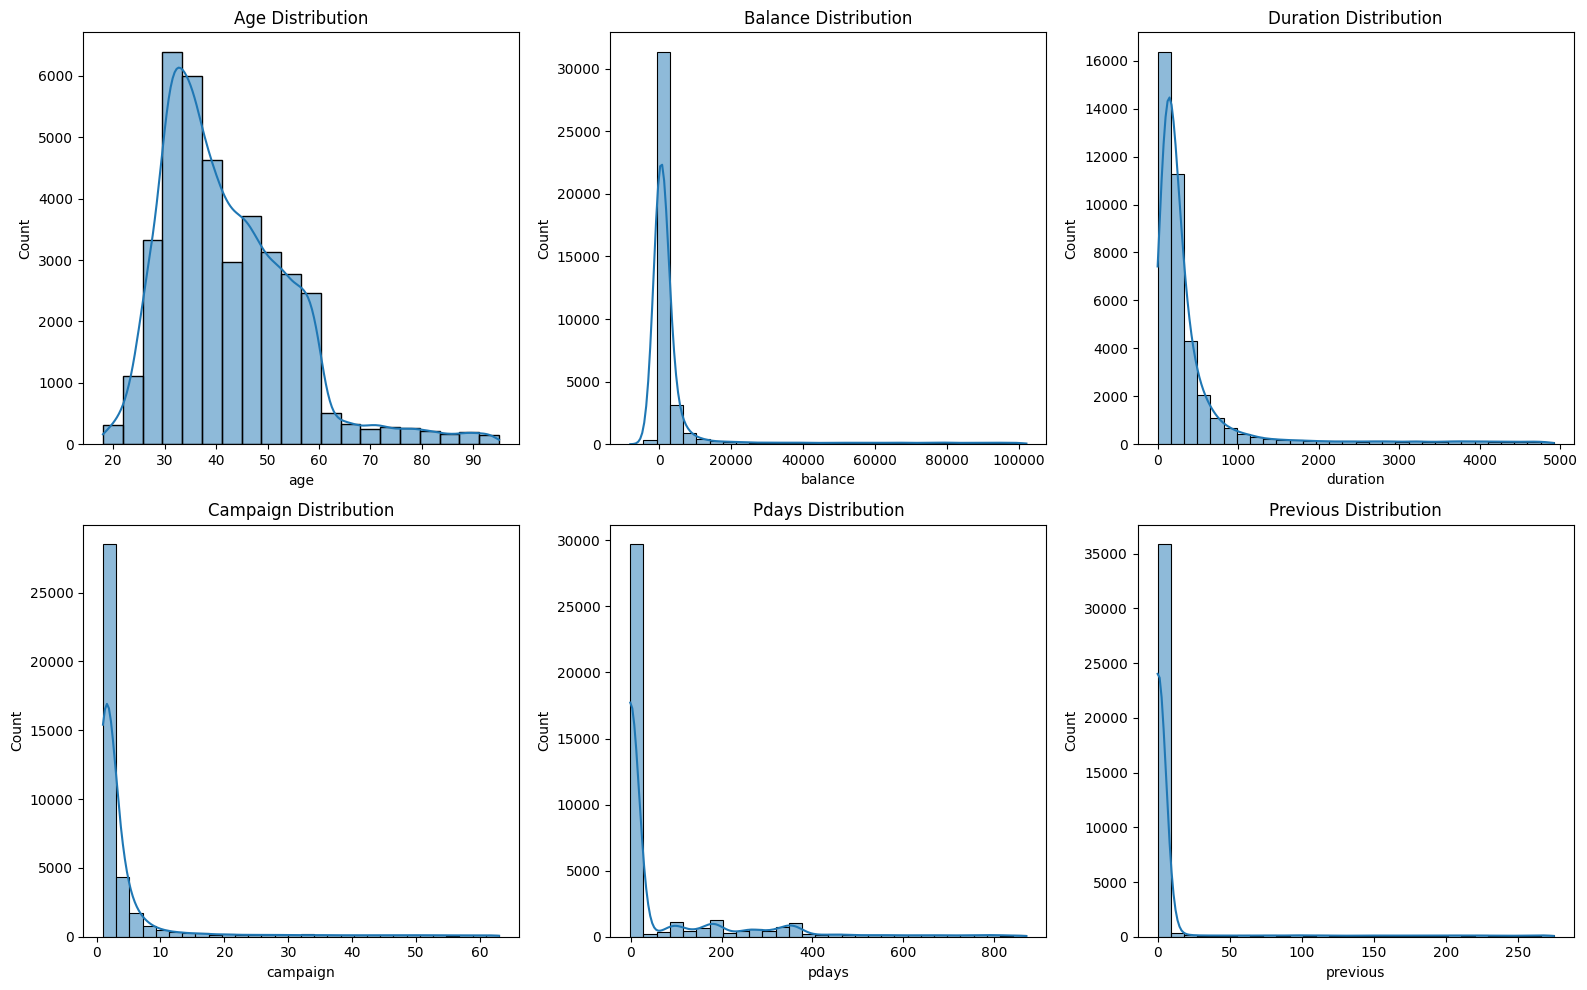

In [136]:
# FEATURE DISTRIBUTION
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# age 
sns.histplot(df_train['age'], bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Age Distribution')

# balance
sns.histplot(df_train['balance'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Balance Distribution')

# duration
sns.histplot(df_train['duration'], bins=30, kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Duration Distribution')

# campaign
sns.histplot(df_train['campaign'], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Campaign Distribution')

# pdays
sns.histplot(df_train['pdays'], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Pdays Distribution')

# previous
sns.histplot(df_train['previous'], bins=30, kde=True, ax=axes[1, 2])
axes[1, 2].set_title('Previous Distribution')

plt.tight_layout()
plt.show()


# mean > median

### Age Distribution
- Most clients fall within the 30–40 age group, with a steep decline in counts for older age groups.
- There is a noticeable tail for older clients, suggesting a few clients above 60.

### Balance Distribution
- Client balances are heavily skewed towards zero, with most having a very low or zero balance.
- A small number of clients have significantly high balances, resulting in a long tail.

### Duration Distribution
- The call duration of marketing campaigns is also skewed, with most calls being short (under 500 seconds).
- There are a few outliers with extremely long call durations.

### Campaign Distribution
- Most clients were contacted 1–3 times, with a sharp drop-off in frequency as the number of calls increases.
- A few clients experienced a very high number of contacts, which may indicate inefficiencies or over-targeting.

### Pdays Distribution
- A large majority of clients have a `pdays` value of 999, indicating no prior contact.
- For clients with prior contacts, there is a wide range, but most are clustered around lower values.

### Previous Distribution
- Most clients had no or very few previous contacts, with a sharp drop as the number of contacts increases.
- This suggests that many clients are being reached out to for the first time.

---

### Key Observations
1. There is a general skewness in all distributions, indicating uneven data.
2. Features like **`balance`**, **`duration`**, and **`pdays`** might require scaling or transformation for modeling.
3. Outliers exist in several features (e.g., `balance`, `duration`, `campaign`), which may impact modeling accuracy.


<Axes: >

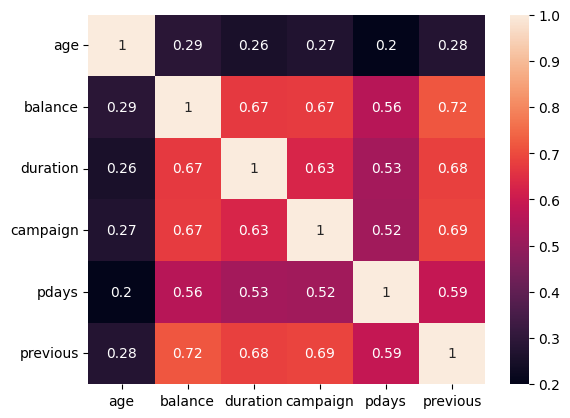

In [137]:
# CORRELATION MATRIX
sns.heatmap(df_train.corr(numeric_only=True), annot=True)

## Correlation Analysis

### High Correlations
- **`balance` and `previous` (0.72):** Indicates clients with higher balances tend to have more previous interactions.
- **`balance` and `duration` (0.67):** Longer call durations are associated with clients having higher balances.
- **`duration` and `campaign` (0.63):** More frequent contacts tend to involve longer calls.
- **`campaign` and `previous` (0.69):** Clients with more prior contacts are contacted more frequently.

### Moderate Correlations
- **`pdays` (0.56–0.59):** Indicates that the time since the previous contact impacts variables like balance, campaign, and previous contacts.

### Low Correlations
- **`age` (~0.2–0.3):** Suggests client age has minimal direct influence on other features.

---

### Key Observations
1. **Multicollinearity Concerns**:
   - Strong correlations between variables like `balance`, `previous`, and `duration` suggest potential multicollinearity issues that may impact predictive modeling.
2. **Weak Correlations**:
   - Features like `age` might have a limited direct impact on the target variable unless they interact with other features.
3. **Recommendations**:
   - Consider feature engineering or dimensionality reduction techniques (e.g., PCA) if multicollinearity significantly affects model performance.


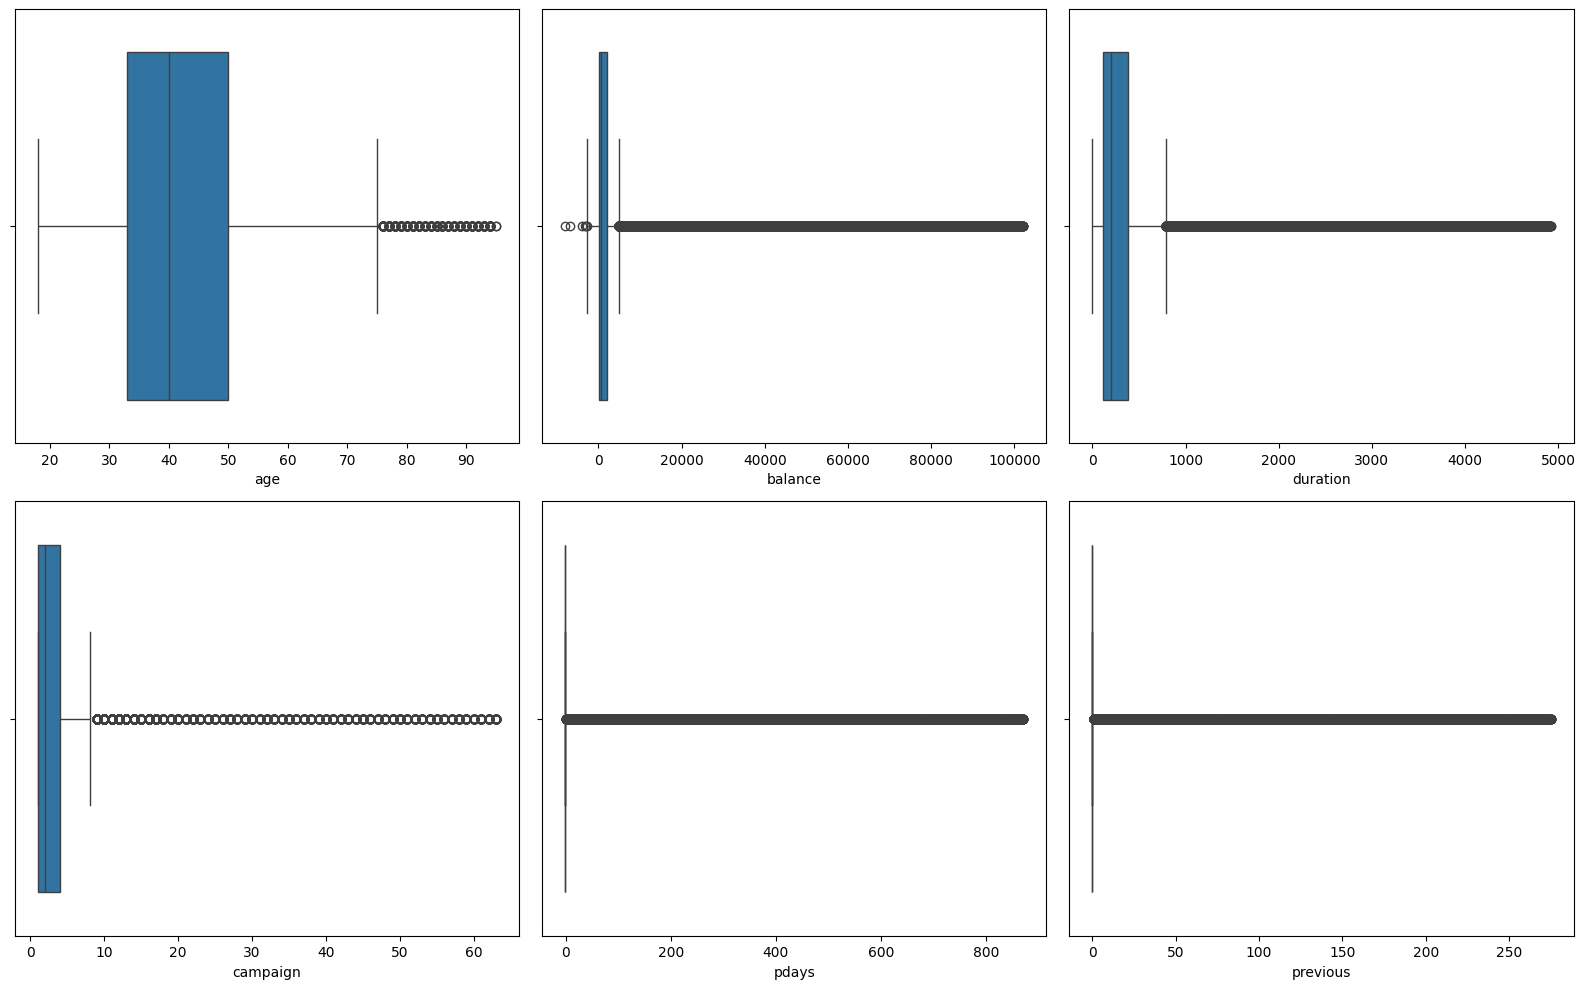

In [138]:
# BOX PLOT 
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

for i, feature in enumerate(features):
    ax = axes[i // 3, i % 3]  
    sns.boxplot(x=df_train[feature], ax=ax)  
    # ax.set_title(f'Box Plot of {feature}')    

plt.tight_layout()
plt.show()

## Boxplot Analysis 
### Age
- No major outliers in the `age` feature, but there is a slight right skew.
- The majority of clients are aged 30–50, aligning with earlier observations.

### Balance
- Numerous outliers in the `balance` feature, with some values reaching as high as 100,000.
- Most clients have balances near zero, with the interquartile range (IQR) being quite narrow.

### Duration
- Significant outliers are present, with some call durations exceeding 4,000 seconds.
- The bulk of call durations are relatively short, as indicated by the narrow IQR.

### Campaign
- A large number of outliers exist, with some clients contacted over 60 times.
- The IQR indicates most clients were contacted fewer than 5 times, suggesting over-contacting is rare but does occur.

### Pdays
- Most data points cluster at 999 (no prior contact), but a few significant outliers appear for clients contacted more recently.
- The narrow IQR suggests limited variability for clients who were previously contacted.

### Previous
- Numerous outliers, with a few clients having over 200 previous contacts.
- Most clients have very few previous contacts (median close to zero).

---

### Key Observations
1. **Prevalence of Outliers**:
   - Outliers are prevalent in features like `balance`, `duration`, `campaign`, `pdays`, and `previous`, which may impact model performance.
   - Consider handling outliers through capping, transformation, or removal.

2. **Clean Features**:
   - Features like `age` are relatively clean and may require minimal preprocessing.

3. **Normalization and Scaling**:
   - The distributions and extreme values suggest a need for careful normalization or scaling to ensure features are suitable for modeling.


In [139]:
# DESCRIBE
df_train.describe()

,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


### Age
- **Mean**: 42.1; **Median**: 40 — indicates a slightly older population with a normal distribution.
- **Range**: Minimum age is 18, and the maximum is 95, covering a wide range of clients.

### Balance
- **Mean**: 5,441.78; **Standard Deviation (std)**: 16,365.29 — suggests substantial variability in balances.
- **Negative balances**: Minimum of -8,019 indicates debts or overdrafts in the dataset.
- **75th Percentile**: 2,030 — shows most clients hold relatively low balances compared to the maximum of 102,127.

### Duration
- **Mean**: 439 seconds (~7 minutes); **std**: 769 — high variability.
- **Median**: 197 seconds — many calls are short, with outliers inflating the mean.
- **Max**: 4,918 seconds (~82 minutes) — exceptionally long calls.

### Campaign
- **Mean**: 5.1 contacts; **std**: 9.89 — high variability due to over-contacting for some clients.
- **Median**: 2 calls; **75th Percentile**: 4 calls — indicates most clients are contacted fewer than 5 times.
- **Max**: 63 calls — highlights potential inefficiencies in targeting strategies.

### Pdays
- **Median**: -1 — indicates no prior contact for most clients.
- **Range**: Some clients had follow-ups within 871 days, but high std (160.94) suggests large variability.

### Previous
- **Median**: 0 — shows no previous contact for most clients.
- **Max**: 275 previous contacts — indicates significant outliers.

---

### Key Observations

#### Outliers:
- **Features with extreme values**: `balance`, `duration`, `campaign`, and `previous` have significant outliers, which may require handling (e.g., capping or transformation).
- **Special cases in `pdays`**: The significant cluster at -1 might indicate missing data or require separate treatment.

#### Skewed Features:
- **Right-skewed distributions**: Features like `balance` and `duration` are heavily skewed, suggesting the need for transformations (e.g., log transformation).

#### Potential Issues:
- **Negative values in `balance`**: May indicate debts or special cases requiring investigation.
- **Outliers in `campaign`**: Could point to inefficiencies in marketing strategies.

#### Distribution Insights:
- **Features with minimal skew**: `age` and `campaign` are less skewed and align more closely with typical values, requiring minimal scaling.


In [140]:
# MISSING VALUES
df_train.isnull().sum()

last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64

### Features with Significant Missing Values:
- **`contact` (10,336 missing)**: 
  - Approximately **26.3%** of rows have missing data for the contact method.
  - This large proportion of missing values may impact the feature's utility in predictive modeling.
- **`poutcome` (29,451 missing)**: 
  - Missing for about **75%** of the dataset.
  - This is likely because most clients did not participate in prior campaigns, making the data inherently sparse.

### Features with Moderate Missing Values:
- **`education` (1,467 missing)**:
  - About **3.7%** of rows have missing data, requiring imputation or categorization as "unknown."
- **`job` (229 missing)**:
  - A small percentage (**~0.6%**) of rows are missing. This can be easily handled through imputation or categorization.

### Features with No Missing Values:
- Critical features such as **`age`**, **`balance`**, **`duration`**, **`campaign`**, **`pdays`**, **`previous`**, and **`target`** are complete, making them reliable for modeling.

---

## Recommended Actions

### 1. Impute Missing Values:
- **For `job`, `education`, and `contact`**:
  - Use **mode imputation** to fill missing values since these are categorical features.
- **For `poutcome`**:
  - Categorize missing values as **"unknown"** to indicate no prior campaign outcomes.

### 2. Consider Feature Engineering:
- **High Missing Rates**:
  - Assess whether features like **`contact`** and **`poutcome`** significantly improve model performance. If not, consider **dropping** them from the dataset.

### 3. Validate Data Patterns:
- **Investigate Missing Values**:
  - Analyze why features like **`contact`** and **`poutcome`** have high missing rates. Ensure the missingness is not biased or affecting certain subsets of the data.

### 4. Use "Unknown" Labels:
- **For Categorical Variables**:
  - Replace missing values with an **"unknown"** category, especially for features like **`job`**, **`education`**, and **`poutcome`** to retain all data for modeling.



In [141]:
# DATA TYPES
print(df_train.dtypes)

last contact date    object
age                   int64
job                  object
marital              object
education            object
default              object
balance               int64
housing              object
loan                 object
contact              object
duration              int64
campaign              int64
pdays                 int64
previous              int64
poutcome             object
target               object
dtype: object


### Numerical Features (`int64`):
- **Features**: `age`, `balance`, `duration`, `campaign`, `pdays`, `previous`
  - These are continuous or discrete numerical features.
  - Can be used directly in models after **scaling** or **transformations** (if needed).
  - **Outliers**:
    - Features like `balance`, `duration`, and `campaign` contain potential outliers that should be carefully handled.

### Categorical Features (`object`):
- **Features**: `job`, `marital`, `education`, `default`, `housing`, `loan`, `contact`, `poutcome`, `target`
  - Require encoding to be used in machine learning models.
  - **Encoding Strategies**:
    - **One-Hot Encoding**: For features with a small number of unique categories (e.g., `marital`, `default`).
    - **Label Encoding**: For ordinal categories, if applicable.

### High Missing Values:
- **Features**: `contact` and `poutcome`
  - Missing data should be imputed, e.g., using an **"unknown"** category.

### Special Case - `last contact date` (`object`):
- Likely represents a **date** or **timestamp**. Can be converted to a **datetime** format for feature engineering.
- **Possible Engineered Features**:
  - Day of the week or month.
  - Elapsed time since the last contact to identify patterns.

### Target Feature (`target`):
- The target variable is categorical, likely representing a **binary classification problem** (e.g., "yes" or "no").
- Should be converted to a **numerical format** (e.g., `1` for "yes" and `0` for "no") for modeling.

---

## Recommended Actions

### 1. Handle Numerical Features:
- **Standardization/Normalization**:
  - Scale continuous features like `age`, `balance`, and `duration` if required by algorithms such as Logistic Regression or Neural Networks.
- **Outlier Treatment**:
  - Address outliers in `balance` and `duration` to avoid skewing the model.

### 2. Process Categorical Features:
- **Encoding**:
  - Use **One-Hot Encoding** for small-category variables like `marital` and `default`.
  - Use **Label Encoding** for ordinal categories if they exist.
- **Missing Values**:
  - Impute missing data for `education`, `job`, `contact`, and `poutcome`.
  - Replace missing values in categorical features with an **"unknown"** category.

### 3. Feature Engineering:
- **From `last contact date`**:
  - Extract new features like the day of the week, month, or time elapsed since the last contact.
  
### 4. Ensure Compatibility:
- Verify that data type conversions and imputations are correct.
- Check that the data is compatible with the machine learning pipeline.



In [142]:
# FEATURE ENGINEERING
def feature_engineering(df):
    df['last contact date'] = pd.to_datetime(df['last contact date'], errors='coerce')
    
    df['contact_month'] = df['last contact date'].dt.month
    df['contact_day'] = df['last contact date'].dt.day



    # days since last contact
    latest_date = df['last contact date'].max()
    df['days_since_contact'] = (latest_date - df['last contact date']).dt.days

    # previous_contacted
    df['never_contacted'] = df['pdays'].apply(lambda x: 1 if x == -1 else 0)


    # Binning 'age'
    bins = [18, 25, 35, 45, 55, 65, 100]
    labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '66+']
    df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)

    # Binning 'balance'
    df['balance_category'] = pd.cut(df['balance'], 
                                    bins=[-float('inf'), 0, 1000, 3000, float('inf')], 
                                    labels=['negative', 'low', 'medium', 'high'])
    
    # financial_risk
    df['financial_risk'] = df.apply(
        lambda row: 'high' if row['housing'] == 'yes' and row['loan'] == 'yes' else 
                    'medium' if row['housing'] == 'yes' or row['loan'] == 'yes' else 
                    'low', axis=1
    )

    # drop unnecessary columns
    df = df.drop(columns=['last contact date', 'poutcome', 'pdays'])


    return df

feature_engineer_transformer = FunctionTransformer(feature_engineering)


# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------

# ordinal categories for specific columns
education_order = ['primary', 'secondary', 'tertiary']
balance_category_order = ['negative', 'low', 'medium', 'high']
financial_risk_order = ['low', 'medium', 'high']


# columns
ordinal_cols = ['education', 'balance_category', 'financial_risk']
nominal_cols = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'contact_month']
num_col = ['age', 'balance', 'duration', 'campaign', 'previous', 'contact_day', 'days_since_contact']


# Ordinal pipeline
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('ordinal', OrdinalEncoder(categories=[
        education_order,balance_category_order, financial_risk_order
    ]))  
])

# Nominal pipeline
nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))    
])

# Numerical pipeline
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())                 
])


# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_col),                
        ('ordinal', ordinal_transformer, ordinal_cols),    
        ('nominal', nominal_transformer, nominal_cols)     
    ]
)

print('----loaded the pipelines----')

----loaded the pipelines----


In [143]:
# Split the data
x = df_train.drop(columns=['target'])
y = df_train['target'].apply(lambda x: 1 if x == 'yes' else 0)
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)


## XGBOOST

In [ ]:

# XGB pipeline
xgb_model = Pipeline(steps=[
    ('feature_engineering', feature_engineer_transformer),
    ('preprocessor', preprocessor),

    ('classifier', XGBClassifier(
        random_state=42,
        eval_metric='logloss'
    )),
])


# parameter grid
param_grid_xgb = {
    'classifier__n_estimators': [50, 100, 200, 300, 500],  # Increase number of trees
    'classifier__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],  # More learning rates
    'classifier__max_depth': [3, 5, 7, 9, 12, 15],  # Deeper trees for more complex models
    'classifier__min_child_weight': [1, 3, 5, 7, 10],  # More granular weight for children
    'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Increase the range for sampling
    'classifier__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # Range for feature sampling
    'classifier__gamma': [0, 0.1, 0.2, 0.3, 0.5, 1.0],  # Explore more values for gamma
    'classifier__scale_pos_weight': [1, 2, 3, 5, 10],  # Adjust scale for imbalanced classes
    'classifier__reg_alpha': [0, 0.1, 0.3, 0.5],  # L1 regularization to prevent overfitting
    'classifier__reg_lambda': [0, 0.1, 0.3, 0.5, 1.0],  # L2 regularization
}



# RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid_xgb,
    n_iter=50,
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

# Print the best parameters
print("Best parameters found:", random_search.best_params_)

# Fit the model with the best parameters
xgb_model.set_params(**random_search.best_params_)
xgb_model.fit(x_train, y_train)



# Predictions on validation and test set
y_valid_pred = xgb_model.predict(x_valid)
test_pred = xgb_model.predict(df_test)


# evaluating model
f1 = f1_score(y_valid, y_valid_pred, average='macro')
print(f'f1 score on validation_set: {f1}')

accuracy = accuracy_score(y_valid, y_valid_pred)
print(f'accuracy on validation set: {accuracy}')

# classification report
print(classification_report(y_valid, y_valid_pred))


# -------------------------------------------------------------------------
'''
Best parameters found: {'classifier__subsample': 0.9, 'classifier__scale_pos_weight': 3, 'classifier__reg_lambda': 0,
'classifier__reg_alpha': 0.5, 'classifier__n_estimators': 100, 'classifier__min_child_weight': 3, 'classifier__max_depth': 7,
'classifier__learning_rate': 0.05, 'classifier__gamma': 0, 'classifier__colsample_bytree': 0.7}

f1 score on validation_set: 0.7707327262271365
accuracy on validation set: 0.8597475455820477
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      6677
           1       0.52      0.80      0.63      1166

    accuracy                           0.86      7843
   macro avg       0.74      0.83      0.77      7843
weighted avg       0.89      0.86      0.87      7843
'''



## RANDOM FOREST 

In [ ]:

# Random Forest pipeline
rf_model = Pipeline(steps=[
    ('feature_engineering', feature_engineer_transformer),
    ('preprocessor', preprocessor),

    ('classifier', RandomForestClassifier(
        random_state=42,
        class_weight='balanced'
    )),
])


# parameter grid
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200, 300, 500],  # Number of trees in the forest
    'classifier__max_depth': [3, 5, 7, 9, 12, 15, None],  # Maximum depth of the trees
    'classifier__min_samples_split': [2, 5, 10, 20],  # Minimum number of samples required to split an internal node
    'classifier__min_samples_leaf': [1, 2, 4, 10],  # Minimum number of samples required to be at a leaf node
    'classifier__max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'classifier__bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
    'classifier__criterion': ['gini', 'entropy'],  # The function to measure the quality of a split
    'classifier__warm_start': [True, False],  # Reuse the solution of the previous call to fit and add more estimators to the ensemble
}



# RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_grid_rf,
    n_iter=50,
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

# best parameters
print("Best parameters found:", random_search.best_params_)

# Fit the model with the best parameters
rf_model.set_params(**random_search.best_params_)
rf_model.fit(x_train, y_train)



# Predictions on validation and test set
y_valid_pred = rf_model.predict(x_valid)
test_pred = rf_model.predict(df_test)

# evaluating model
f1 = f1_score(y_valid, y_valid_pred, average='macro')
print(f'f1 score on validation_set: {f1}')

accuracy = accuracy_score(y_valid, y_valid_pred)
print(f'accuracy on validation set: {accuracy}')

# classification report
print(classification_report(y_valid, y_valid_pred))


# --------------------------------------------------------------------------------
'''
Best parameters found: {'classifier__warm_start': True, 'classifier__n_estimators': 500, 'classifier__min_samples_split': 20, 
'classifier__min_samples_leaf': 2, 'classifier__max_features': 'log2',
'classifier__max_depth': None, 'classifier__criterion': 'gini', 'classifier__bootstrap': False}

f1 score on validation_set: 0.7652461846010233
accuracy on validation set: 0.8522249139359939
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      6677
           1       0.50      0.82      0.62      1166

    accuracy                           0.85      7843
   macro avg       0.73      0.84      0.77      7843
weighted avg       0.90      0.85      0.87      7843
'''

## LOGISTIC REGRESSION

In [ ]:

# Logistic Regression pipeline
logreg_model = Pipeline(steps=[
    ('feature_engineering', feature_engineer_transformer),
    ('preprocessor', preprocessor),

    ('classifier', LogisticRegression(random_state=42)),
])


# Define the parameter grid for RandomizedSearchCV
param_grid_logreg = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Regularization types
    'classifier__C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'classifier__solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],  # Optimization solvers
    'classifier__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],  # ElasticNet mixing parameter (only for 'elasticnet')
    'classifier__class_weight': [None, 'balanced'],  # Handles class imbalance
    'classifier__max_iter': [100, 200, 500, 1000],  # Maximum iterations for convergence
    'classifier__tol': [1e-4, 1e-3, 1e-2],  # Tolerance for stopping criteria
    'classifier__fit_intercept': [True, False],  # Whether to fit the intercept term
    'classifier__multi_class': ['auto', 'ovr', 'multinomial'],  # Type of classification
}


# RandomizedSearchCV
random_search = RandomizedSearchCV(
    logreg_model,
    param_distributions=param_grid_logreg,
    n_iter=100,
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

# best parameters
print("Best parameters found:", random_search.best_params_)

# Fit the model with the best parameters
logreg_model = random_search.best_estimator_
logreg_model.fit(x_train, y_train)



# Predictions on validation and test set
y_valid_pred = logreg_model.predict(x_valid)
test_pred = logreg_model.predict(df_test)

# evaluating model
f1 = f1_score(y_valid, y_valid_pred, average='macro')
print(f'f1 score on validation_set: {f1}')

accuracy = accuracy_score(y_valid, y_valid_pred)
print(f'accuracy on validation set: {accuracy}')

# Generate and print the classification report
print(classification_report(y_valid, y_valid_pred))


# -------------------------------------------------------------------------------------
'''
Best parameters found: {'classifier__tol': 0.001, 'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 
'classifier__multi_class': 'ovr', 'classifier__max_iter': 500, 'classifier__l1_ratio': 0.7, 
'classifier__fit_intercept': False, 'classifier__class_weight': 'balanced', 'classifier__C': 1}

f1 score on validation_set: 0.7102211492042179
accuracy on validation set: 0.8149942623995919
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      6677
           1       0.43      0.72      0.54      1166

    accuracy                           0.81      7843
   macro avg       0.69      0.78      0.71      7843
weighted avg       0.87      0.81      0.83      7843
'''

## MODEL COMPARISON

In [ ]:
# LEARNING CURVES
def plot_learning_curves(models, model_names, x_train, y_train, cv=5, scoring='accuracy'):
    # Create figure
    fig, axes = plt.subplots(1, len(models), figsize=(20, 6), sharey=True)
    
    for model, name, ax in zip(models, model_names, axes):
        # Generate learning curve data
        train_sizes, train_scores, valid_scores = learning_curve(
            model, x_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
        )
        
        # Calculate mean and std for training and validation scores
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        valid_mean = np.mean(valid_scores, axis=1)
        valid_std = np.std(valid_scores, axis=1)
        
        # Plot learning curves
        ax.plot(train_sizes, train_mean, label='Training Score', marker='o', lw=2)
        ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
        ax.plot(train_sizes, valid_mean, label='Validation Score', marker='o', lw=2)
        ax.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.2)
        
        # Add title and labels
        ax.set_title(name)
        ax.set_xlabel("Training Size")
        if ax == axes[0]:
            ax.set_ylabel(scoring.capitalize())
        
        # Add legend
        ax.legend(loc="best")
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage
models = [xgb_model, rf_model, logreg_model]
model_names = ["XGBoost", "Random Forest", "Logistic Regression"]
plot_learning_curves(models, model_names, x_train, y_train)


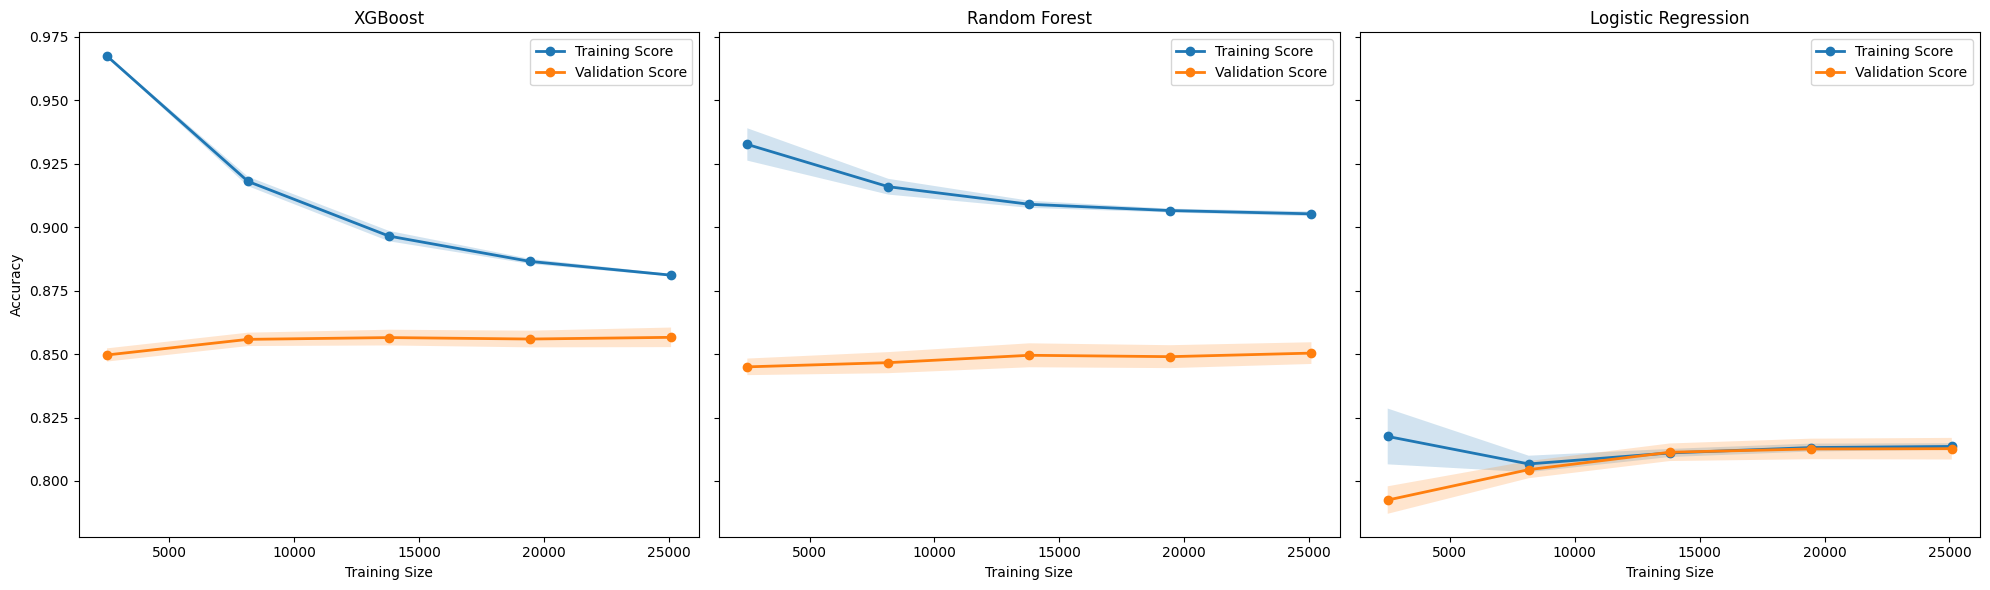

### Insights from the Learning Curve Analysis

### XGBoost
1. **Training Score**:
   - Starts very high (~0.95) for small training sizes, indicating potential overfitting.
   - Decreases with larger training sizes but remains stable.
2. **Validation Score**:
   - Consistently improves as training size increases and stabilizes, showing good generalization.

### Random Forest
1. **Training Score**:
   - High initially but gradually decreases as the training size increases.
2. **Validation Score**:
   - Steady across all training sizes, indicating robustness and minimal overfitting.

### Logistic Regression
1. **Training Score**:
   - Starts relatively low compared to tree-based models but slightly improves with training size.
2. **Validation Score**:
   - Gradually increases with training size but converges closely with the training score, suggesting underfitting.

### Conclusion
- **XGBoost**: Performs well, balancing training and validation accuracy as data size increases.
- **Random Forest**: Robust and consistent but slightly less flexible compared to XGBoost.
- **Logistic Regression**: Struggles with both training and validation accuracy, indicating limitations for this dataset.
---


In [ ]:
# CONFUSION MATRIX
def plot_confusion_matrices(models, model_names, x_valid, y_valid):
    # Create figure
    fig, axes = plt.subplots(1, len(models), figsize=(20, 6))
    
    for model, name, ax in zip(models, model_names, axes):
        # Predict on the validation set
        y_pred = model.predict(x_valid)
        
        # Display confusion matrix
        ConfusionMatrixDisplay.from_predictions(
            y_valid, y_pred, ax=ax, cmap="Blues"
        )
        ax.set_title(name)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage with your validation set
models = [xgb_model, rf_model, logreg_model]
model_names = ["XGBoost", "Random Forest", "Logistic Regression"]
plot_confusion_matrices(models, model_names, x_valid, y_valid)


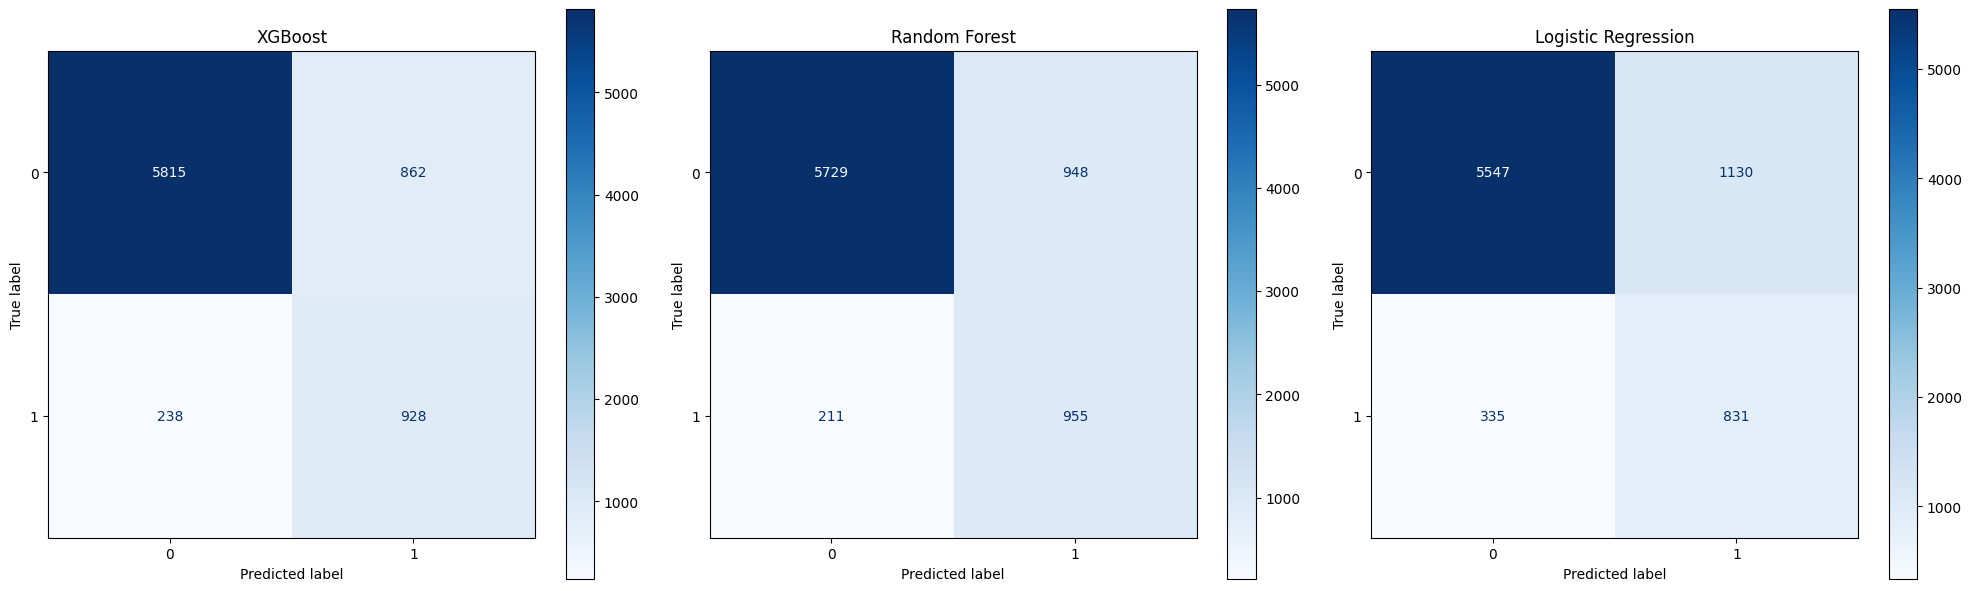

### Insights from Confusion Matrices

#### 1. **XGBoost**
   - **True Positive Rate (Subscribed):** 79.5%
   - **False Positive Rate:** 13.1%
   - **Key Insight:** Strong balance between precision and recall, with good performance across both classes.

#### 2. **Random Forest**
   - **True Positive Rate (Subscribed):** 82.3% (highest)
   - **False Positive Rate:** 14.3%
   - **Key Insight:** Best for predicting the "Subscribed" class but slightly higher false positives.

#### 3. **Logistic Regression**
   - **True Positive Rate (Subscribed):** 72.2% (lowest)
   - **False Positive Rate:** 16.9% (highest)
   - **Key Insight:** Struggles with the "Subscribed" class and has the highest misclassification rates.


### Conclusion
- **Best Overall:** XGBoost (balance between both classes)
- **Best for Subscribed Predictions:** Random Forest
- **Needs Improvement:** Logistic Regression

---



In [ ]:
# ROC CURVES
def plot_roc_curves(models, model_names, x_valid, y_valid):
    # Create figure
    plt.figure(figsize=(20, 6))
    
    for model, name in zip(models, model_names):
        # Predict probabilities for the positive class
        y_prob = model.predict_proba(x_valid)[:, 1]
        
        # Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y_valid, y_prob)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    
    # Plot baseline
    plt.plot([0, 1], [0, 1], 'k--', label="Chance Level (AUC = 0.50)")
    
    # Add labels, title, and legend
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage with your validation set
models = [xgb_model, rf_model, logreg_model]
model_names = ["XGBoost", "Random Forest", "Logistic Regression"]
plot_roc_curves(models, model_names, x_valid, y_valid)


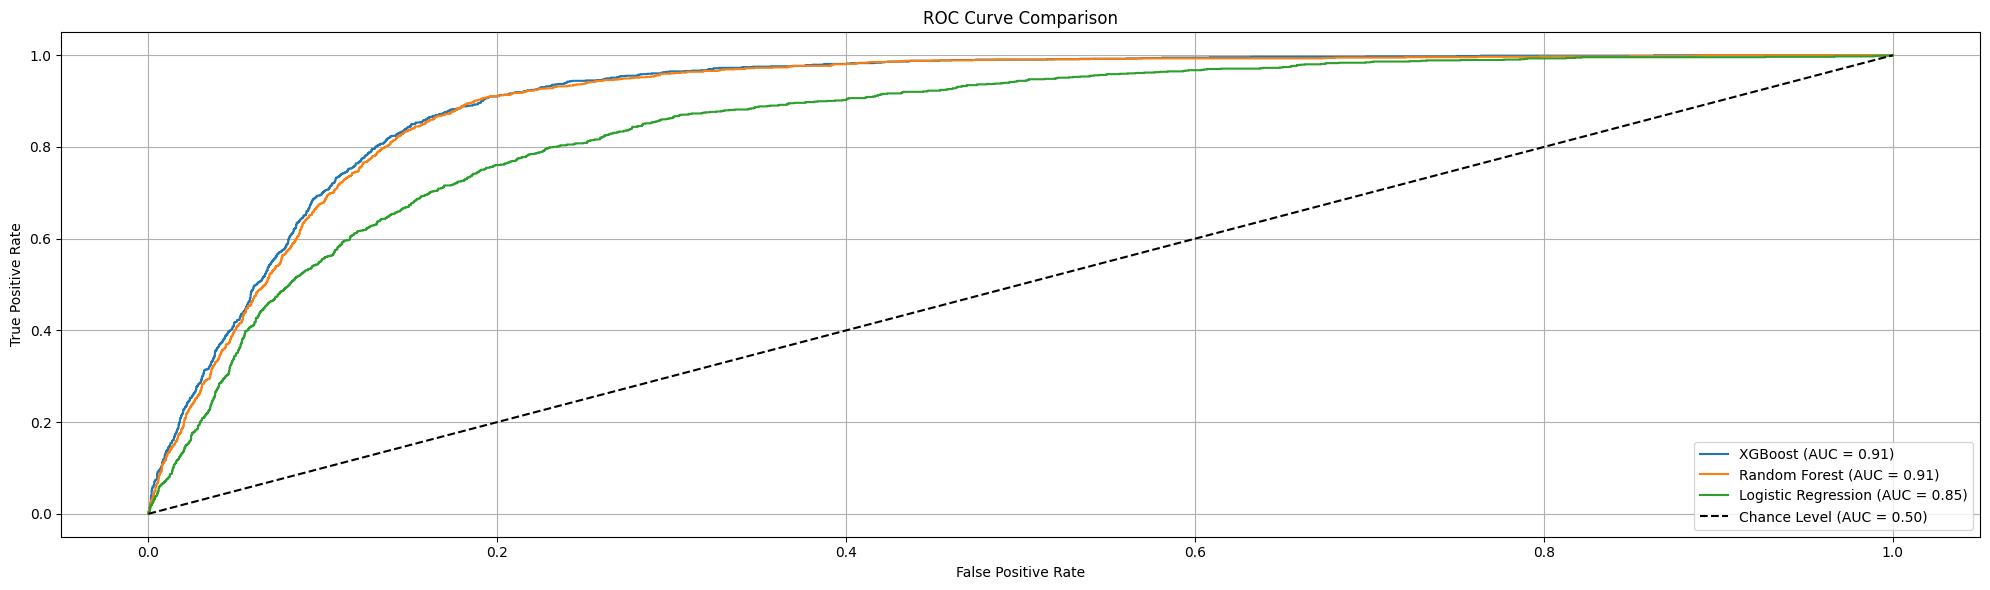
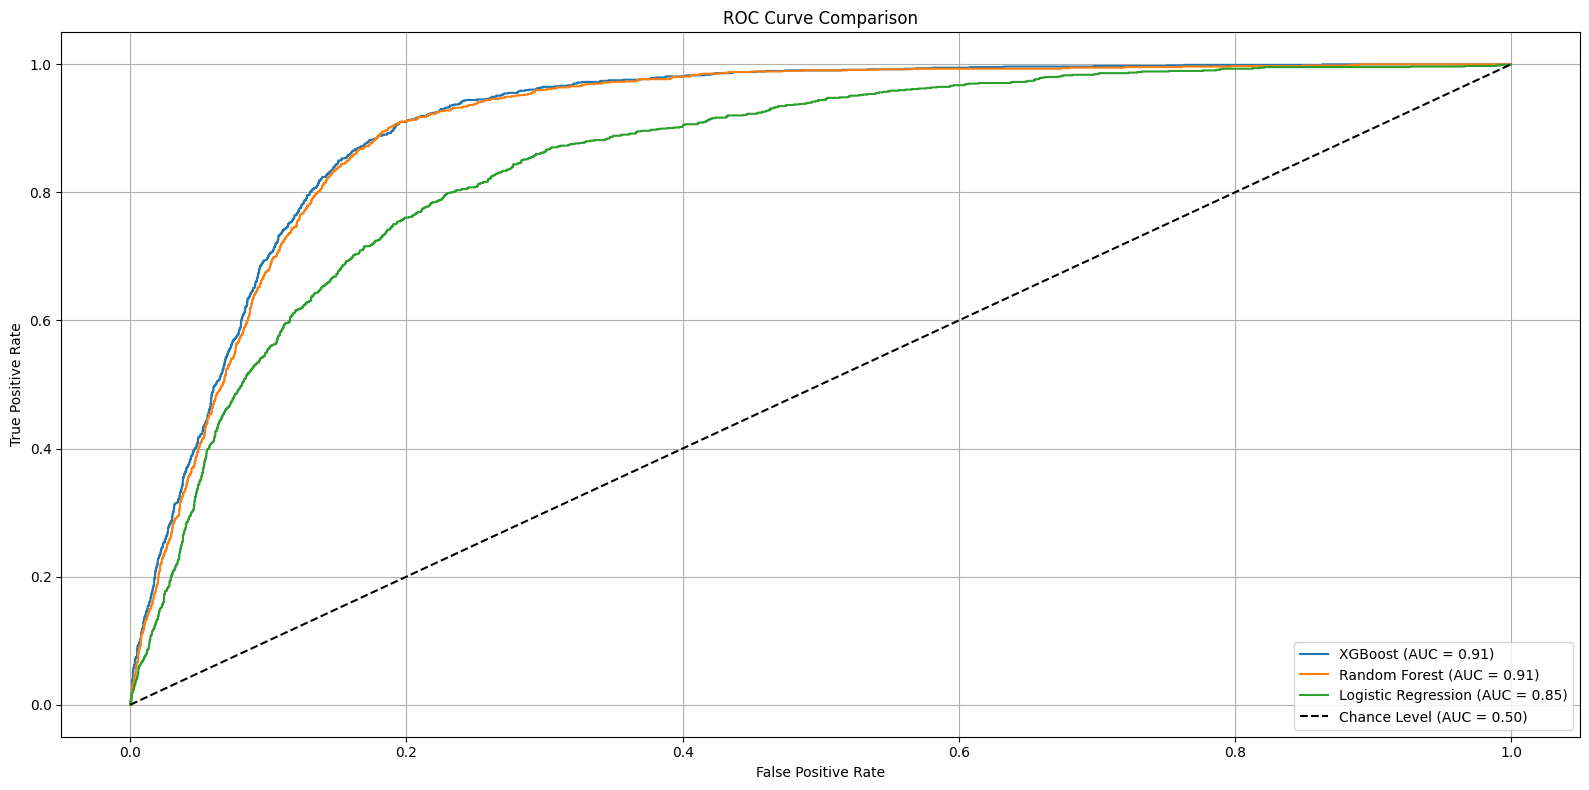

### Insights from the ROC Curve Analysis

1. **XGBoost and Random Forest**:
   - Both models have high performance with an **AUC = 0.91**, indicating strong classification capability.

2. **Logistic Regression**:
   - Shows decent performance with an **AUC = 0.8**, though slightly less effective compared to tree-based models.

3. **Comparison**:
   - XGBoost and Random Forest outperform Logistic Regression, suggesting non-linear relationships in the data are better captured by these models.

4. **Random Guess Baseline**:
   - Represented by the diagonal line, highlighting that all models significantly outperform random guessing.

### Conclusion
XGBoost and Random Forest are optimal choices based on the ROC analysis, delivering robust performance for this classification task.

---


In [ ]:
# PRECISION-RECALL CURVES
def plot_precision_recall_curves(models, model_names, x_valid, y_valid):
    # Create figure
    plt.figure(figsize=(20, 6))
    
    for model, name in zip(models, model_names):
        # Predict probabilities for the positive class
        y_prob = model.predict_proba(x_valid)[:, 1]
        
        # Compute Precision-Recall curve and Average Precision (AP) score
        precision, recall, thresholds = precision_recall_curve(y_valid, y_prob)
        avg_precision = average_precision_score(y_valid, y_prob)
        
        # Plot Precision-Recall curve
        plt.plot(recall, precision, label=f"{name} (AP = {avg_precision:.2f})")
    
    # Add labels, title, and legend
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve Comparison")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage with your validation set
models = [xgb_model, rf_model, logreg_model]
model_names = ["XGBoost", "Random Forest", "Logistic Regression"]
plot_precision_recall_curves(models, model_names, x_valid, y_valid)


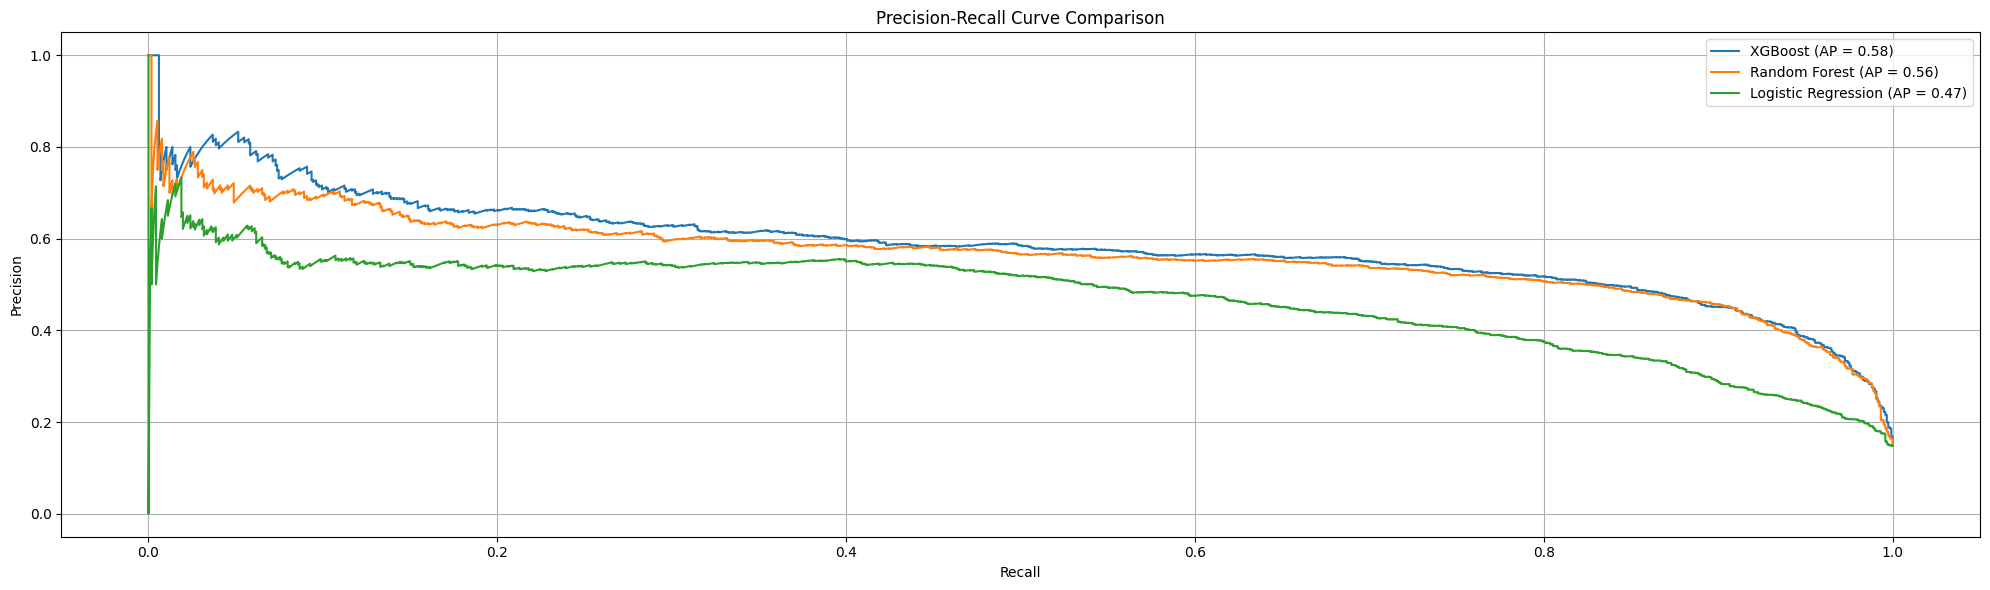

### Insights from the Precision-Recall Curve Analysis

1. **XGBoost**:
   - Achieves the highest Average Precision (AP = 0.58), indicating better performance in identifying positive cases with precision and recall.

2. **Random Forest**:
   - Closely follows with an **AP = 0.56**, performing nearly as well as XGBoost.

3. **Logistic Regression**:
   - Shows the lowest performance with an **AP = 0.47**, struggling more with precision-recall balance compared to tree-based models.

4. **Comparison**:
   - XGBoost slightly outperforms Random Forest, but both models significantly surpass Logistic Regression in terms of precision-recall trade-offs.

### Conclusion
XGBoost and Random Forest remain the top-performing models, with XGBoost slightly better suited for tasks prioritizing precision-recall balance.

---
